# Create Neo4j Database

### Retrieve Required Data

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
import pandas as pd
import pickle
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from pprint import pprint

In [11]:
def normalize_text(text):
    # Lowercase every words
    text = text.lower()
    # Get rid of the punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Get rid of these specific punctuations
    text = re.sub('[‘’“”…]', '', text)
    # Get rid of '\n'
    text = re.sub('\n', '', text)
    return text

In [12]:
# User comedian matrix
matrix_filename = 'full_user_comedian_matrix_OriginalPolarity.pkl'
ucm_df = pd.read_pickle(matrix_filename)
ucm_df.index = [normalize_text(t) for t in ucm_df.index]
ucm_df.columns = [normalize_text(t) for t in ucm_df.columns]
ucm_df

,amy schumer,andy woodhull,arsenio hall,aziz ansari,bert kreischer,bill burr,chris delia,chris rock,dave chappelle,eric andre,...,ronny chieng,roy wood jr,russell peters,sebastian maniscalco,tiffany haddish,tom segura,trevor noah,urzila carlson,vir das,whitney cummings
moons place © with peter moon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.437500
monstaxgang monbebegang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,NaN
ᒪᗩᗪy ᐯoᒪᗪeᗰoᖇt,NaN,0.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
,NaN,NaN,NaN,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
💥warped💥,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.975,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bangzhu,0.520833,0.600000,0.60000,0.0,1.000000,0.6,0.00,0.900,0.15,0.00,...,0.000,0.00,0.60,0.571429,0.45,0.53,0.6,1.00,1.0,0.600000
kevin,1.000000,0.277273,0.72619,0.6,0.600000,0.7,0.55,1.000,0.45,0.77,...,0.125,0.55,0.15,1.000000,0.50,0.00,0.0,0.45,NaN,0.767857
leo,1.000000,0.535714,1.00000,1.0,0.785714,1.0,0.00,0.550,0.55,0.75,...,NaN,NaN,NaN,NaN,NaN,NaN,0.6,NaN,0.6,0.000000


In [13]:
# Training set
X_train_df = pd.read_pickle('X_train.pkl')
Y_train_df = pd.read_pickle('Y_train.pkl')
train_df = pd.concat([X_train_df, Y_train_df], axis=1)
train_df.Name = train_df.Name.apply(normalize_text)
train_df.Comedian = train_df.Comedian.apply(normalize_text)
train_df.head()

,Name,Comedian,Rating
0,respekt,marc maron,0.250000
1,mais abdullatif,ramy youssef,0.600000
2,benito ramirez,roy wood jr,0.541667
3,quarantinewhile,jo koy,0.633333
4,its me,tom segura,0.700000


In [14]:
# Test set
X_test_df = pd.read_pickle('X_test.pkl')
Y_test_df = pd.read_pickle('Y_test.pkl')
test_df = pd.concat([X_test_df, Y_test_df], axis=1)
test_df.Name = test_df.Name.apply(normalize_text)
test_df.Comedian = test_df.Comedian.apply(normalize_text)
test_df.head()

,Name,Comedian,Rating
0,nik d,kenny sebastian,1.000000
1,mr 79,chris rock,0.571667
2,satish rengarajan,joe rogan,0.400000
3,maliah h,iliza shlesinger,0.450000
4,goliath3719,whitney cummings,0.066667


In [15]:
train_df.describe()

,Rating
count,7257.000000
mean,0.604469
std,0.246072
min,0.000000
25%,0.435000
50%,0.600000
75%,0.770000
max,1.000000


In [16]:
t = train_df[['Name','Comedian']]
t[t.duplicated()]

,Name,Comedian


In [17]:
train_df[train_df['Rating']>=0].shape

(7257, 3)

In [18]:
test_df[test_df.Rating>=0].shape

(1815, 3)

In [19]:
test_df[~test_df.Comedian.isin(train_df.Comedian.unique())]

,Name,Comedian,Rating


In [20]:
# Comedian Properties
cp_df = pd.read_excel('ComedianProperties.xlsx')
# Categorize the year of birth of the comedians
cp_df['year group'] = cp_df.year.apply(lambda x: str(x)[:3]+'0s')
# Remove unnecessary columns
cp_df = cp_df.drop(['spouseLabel','children_number','birthdate','year'], axis=1)
# change column names
cp_df.columns = ['Comedian','Citizenship','Ethnicity','Married','Gender','Year']
# Numerize Married Column
cp_df.Married = cp_df.Married.apply(lambda x: str(x))
# Normalize comedian names
cp_df.Comedian = cp_df['Comedian'].apply(normalize_text)
# Set index to comedian
cp_df = cp_df.set_index(cp_df['Comedian'])
# Drop Comedian Column
cp_df = cp_df.drop('Comedian', axis=1)
cp_df.head()

,Citizenship,Ethnicity,Married,Gender,Year
Comedian,,,,,
andy woodhull,United States of America,White,True,male,1980s
ramy youssef,United States of America,Egyptian-American Muslim,False,male,1990s
amy schumer,United States of America,American Jews,True,female,1980s
arsenio hall,United States of America,African Americans,False,male,1950s
aziz ansari,United States of America,Tamil American,False,male,1980s


#### Some comedians have multiple ethnicities

In [21]:
# First extract all kinds of ethnicity
ethnicities = dict()
for e_list in cp_df.Ethnicity.unique():
    for e in e_list.split(','):
        if e.strip() not in ethnicities:
            ethnicities[e.strip()] = len(ethnicities.keys())
        
# Assgin a encoding to each comedian
def encode_ethnicity(text):
    encode = [0 for i in range(len(ethnicities))]
    for e in text.split(','):
        if e.strip() in ethnicities:
            encode[ethnicities[e.strip()]] = 1
    return encode
    
ethnicity_df = cp_df['Ethnicity'].apply(encode_ethnicity)
ethnicity_df = ethnicity_df.apply(pd.Series)
ethnicity_df.columns = [f"Ethnicity_{c}" for c in ethnicity_df.columns]
ethnicity_df.head()

,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,Ethnicity_4,Ethnicity_5,Ethnicity_6,Ethnicity_7,Ethnicity_8,Ethnicity_9,...,Ethnicity_18,Ethnicity_19,Ethnicity_20,Ethnicity_21,Ethnicity_22,Ethnicity_23,Ethnicity_24,Ethnicity_25,Ethnicity_26,Ethnicity_27
Comedian,,,,,,,,,,,,,,,,,,,,,
andy woodhull,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ramy youssef,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
amy schumer,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arsenio hall,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aziz ansari,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
cp_df2 = cp_df.drop('Ethnicity', axis=1)
cp_dummy = pd.get_dummies(cp_df2, drop_first=True)
cp_dummy.head()

,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,Married_True,Gender_male,Year_1950s,Year_1960s,Year_1970s,Year_1980s,Year_1990s
Comedian,,,,,,,,,,,,,,,
andy woodhull,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0
ramy youssef,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
amy schumer,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
arsenio hall,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
aziz ansari,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0


In [23]:
# Append ethnicity back 
cp_dummy = pd.concat([cp_dummy, ethnicity_df], axis=1)
cp_dummy.head()

,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,Married_True,Gender_male,...,Ethnicity_18,Ethnicity_19,Ethnicity_20,Ethnicity_21,Ethnicity_22,Ethnicity_23,Ethnicity_24,Ethnicity_25,Ethnicity_26,Ethnicity_27
Comedian,,,,,,,,,,,,,,,,,,,,,
andy woodhull,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ramy youssef,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
amy schumer,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
arsenio hall,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
aziz ansari,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Comedian & keywords
kw_df = pd.read_excel('keywords_clean.xlsx',index_col=0)
kw_df.Comedian = kw_df.Comedian.apply(normalize_text)
kw_df.head()

,Comedian,Keywords
0,amy schumer,"grow, grows, arrested, schumers, schumer, butt..."
1,andy woodhull,"toast, maze, punishing, punishment, ordered pu..."
2,arsenio hall,"wesley, marching, tiger, grow, plus, bernie, a..."
3,aziz ansari,"randy, randys, harris, texted, writing, writes..."
4,bert kreischer,"marshmallow, leeann, ilas, pajama, glock, leea..."


In [25]:
# Users and Comedians 
users = train_df.Name.unique()
comedians = train_df.Comedian.unique()

### Build the graph in neo4j

In [26]:
from py2neo import Graph, Node, Relationship

In [27]:
def switch_database(database):
    host = "localhost"
    password = "0000"
    graph = Graph(host=host, password=password, name=database) 
    return graph
    

In [19]:
switch_database('neo4j')

Graph('bolt://neo4j@localhost:7687', name='neo4j')

In [22]:
def create_graph(database = 'neo4j', recreate = True, weigh_links = False):    
    graph = switch_database(database)
    
    if recreate:
        # Delete all nodes and relationships
        DELETE_QUERY = "MATCH (n) DETACH DELETE n"
        _ = graph.run(DELETE_QUERY)
    
    # Add all user nodes
    for user in users:
        graph.run("""
        MERGE (:User{name: $user})
        """, user=user)
        
    # Add all comedian nodes
    for comedian in comedians:
        properties = cp_df.loc[comedian]
        graph.run("""
        MERGE (:Comedian{name: $comedian, 
                          ethnicity: $ethnicity,
                          married: $married,
                          gender: $gender,
                          year: $year})
            """,comedian=comedian,
                citizenship=properties['Citizenship'],
                ethnicity=properties['Ethnicity'],
                married=properties['Married'],
                gender=properties['Gender'],
                year=properties['Year'])
        
    # Build relationships for users and comedians
    for k, v in train_df.iterrows():
        u = v['Name']
        c = v['Comedian']
        rating = v['Rating']
        if weigh_links:
            weight = int(rating * 10) + 1 # => rating = 1~11 links
        else:
            weight = 1
        for i in range(weight):
            graph.run("""
            MATCH (u:User{name: $user})
            MATCH (c:Comedian{name: $comedian})
            MERGE (u)-[r:commented_on{rating: $rr, index: $id}]->(c)""", user=u, comedian=c, rr=rating, id=i)
                
    # Add all keyword nodes
    for i, r in kw_df.iterrows():
        comedian = r.Comedian
        keywords = r.Keywords.split(',')
        for word in keywords:
            graph.run("""
            MERGE (k:Keyword{word: $word})
            """, word=word)
            graph.run("""
            MATCH (c:Comedian{name: $comedian})
            MATCH (k:Keyword{word: $word})
            MERGE (c)-[:has_keyword]->(k)""", comedian=comedian, word=word)
            
    return graph

In [23]:
# g_base = create_graph()

In [24]:
# g_sc1 = create_graph('scenario1', weigh_links=True)

In [25]:
# g_sc2 = create_graph('scenario2', weigh_links=True)

# Clustering

In [51]:
from igraph import Graph as IGraph

In [52]:
graph = switch_database('neo4j')

In [53]:
query="""
MATCH (c1:Comedian)-[:has_keyword]->()<-[:has_keyword]-(c2:Comedian)
WHERE ID(c1) < ID(c2)
RETURN c1.name, c2.name, COUNT(*) as weight
ORDER BY weight DESC
LIMIT 10
"""

result = graph.run(query)
for row in result:
    print(row)

'bill burr'	'dave chappelle'	69
'jim jefferies'	'dave chappelle'	60
'bill burr'	'jim jefferies'	57
'jim jefferies'	'iliza shlesinger'	39
'chris rock'	'dave chappelle'	34
'iliza shlesinger'	'dave chappelle'	30
'tom segura'	'jim jefferies'	30
'iliza shlesinger'	'aziz ansari'	29
'aziz ansari'	'dave chappelle'	28
'bill burr'	'iliza shlesinger'	28


In [54]:
query = """
MATCH (k1:Keyword)<-[:has_keyword]-()-[:has_keyword]->(k2:Keyword)
WHERE ID(k1) < ID(k2)
RETURN k1.word, k2.word, COUNT(*) as weight
"""
ig_keyword = IGraph.TupleList(graph.run(query), weights=True)

In [38]:
query="""
MATCH (c1:Comedian)-[:has_keyword]->()<-[:has_keyword]-(c2:Comedian)
WHERE ID(c1) < ID(c2)
RETURN c1.name, c2.name, COUNT(*) as weight
"""
ig_com = IGraph.TupleList(graph.run(query), weights=True)

In [1]:
query="""
MATCH (u1:User)-[c1:commented_on]->()<-[c2:commented_on]-(u2:User)
WHERE ID(u1) < ID(u2) 
RETURN u1.name, u2.name, COUNT(*) as weight
"""

ig_user = IGraph.TupleList(graph.run(query), weights=True)

In [64]:
query="""
MATCH (u:User)-[com1:commented_on]->(c:Comedian)<-[com2:commented_on]-(other:User)
WHERE ID(u) < ID(other)
WITH u, other, COLLECT(com1.rating) as r1, COLLECT(com2.rating) as r2

MATCH (u)-[:commented_on]->(uc:Comedian)
WITH u,other, COLLECT(ID(uc)) AS s1, r1, r2
MATCH (other)-[:commented_on]->(oc:Comedian)
WITH u,other, s1, COLLECT(ID(oc)) AS s2, r1, r2

WITH u,other, gds.alpha.similarity.jaccard(s1,s2) as jaccard, gds.alpha.similarity.cosine(r1,r2) as cosine_sim
RETURN u.name, other.name, jaccard * cosine_sim AS weight
"""

ig_user = IGraph.TupleList(graph.run(query), weights=True)

In [55]:
# Clusters of keywords
keyword_clusters = IGraph.community_walktrap(ig_keyword, weights="weight")
keyword_clusters = keyword_clusters.as_clustering()
len(keyword_clusters)

32

In [40]:
comedian_clusters = IGraph.community_walktrap(ig_com, weights="weight")
comedian_clusters = comedian_clusters.as_clustering()
len(comedian_clusters)

2

In [65]:
user_clusters = IGraph.community_walktrap(ig_user, weights="weight")
user_clusters = user_clusters.as_clustering()
len(user_clusters)

2

In [77]:
user_cluster2 = IGraph.community_multilevel(ig_user, weights='weight')
# user_cluster2 = user_cluster2.as_clustering()
len(user_cluster2)

4

In [79]:
user_cluster2 = IGraph.community_leading_eigenvector(ig_user, weights='weight')
# user_cluster2 = user_cluster2.as_clustering()
len(user_cluster2)

2

In [56]:
def build_nodes(igraph, clusters):
    nodes = [node["name"] for node in igraph.vs]
    nodes = [{"id": x, "label": x} for x in nodes]

    for node in nodes:
        idx = igraph.vs.find(name=node["id"]).index
        node["group"] = clusters.membership[idx]
    return nodes

In [57]:
nodes = build_nodes(ig_keyword, keyword_clusters)
nodes[:10]

[{'id': ' collection demographic',
  'label': ' collection demographic',
  'group': 0},
 {'id': ' openly', 'label': ' openly', 'group': 0},
 {'id': ' expects', 'label': ' expects', 'group': 0},
 {'id': ' sake', 'label': ' sake', 'group': 1},
 {'id': ' investment', 'label': ' investment', 'group': 0},
 {'id': ' observant', 'label': ' observant', 'group': 2},
 {'id': ' arugula', 'label': ' arugula', 'group': 0},
 {'id': ' misogyny needle baiting bait hater',
  'label': ' misogyny needle baiting bait hater',
  'group': 0},
 {'id': ' pouch', 'label': ' pouch', 'group': 0},
 {'id': ' vague warning observation',
  'label': ' vague warning observation',
  'group': 0}]

In [34]:
# pickle.dump(nodes, open('keyword_group.pkl', 'wb'))
# pickle.dump(nodes, open('user_group.pkl', 'wb'))

#### use the user group from knn

In [326]:
user_group = pd.read_pickle('user_group.pkl')
user_group.head()

,Group,User
0,2,respekt
1,3,mais abdullatif
2,3,benito ramirez
3,3,quarantinewhile
4,4,its me


In [330]:
# Retrieve user-id lookup table
graph = switch_database('scenario2')
query = "MATCH (n:User) RETURN ID(n) as u_id, n.name as name"
users = graph.run(query).to_data_frame()
users

,u_id,name
0,0,kay siekkinen
1,1,pratik suryawanshi
2,2,tony soza
3,3,chetna pandey
4,4,сухое молоко
...,...,...
1064,8067,andrew green
1065,8068,smurf unkown
1066,8069,indigo blue
1067,8070,j garcia


In [329]:
users_extend = users.merge(user_group, left_on='name',right_on='User')
users_extend

,u_id,name,Group,User
0,0,kay siekkinen,0,kay siekkinen
1,1,pratik suryawanshi,5,pratik suryawanshi
2,2,tony soza,4,tony soza
3,3,chetna pandey,5,chetna pandey
4,4,сухое молоко,1,сухое молоко
...,...,...,...,...
1064,8067,andrew green,0,andrew green
1065,8068,smurf unkown,5,smurf unkown
1066,8069,indigo blue,4,indigo blue
1067,8070,j garcia,2,j garcia


In [332]:
users_extend = users_extend[['u_id','name','Group']]
users_extend.head()

,u_id,name,Group
0,0,kay siekkinen,0
1,1,pratik suryawanshi,5
2,2,tony soza,4
3,3,chetna pandey,5
4,4,сухое молоко,1


In [333]:
# Build group nodes in the graph 
graph = switch_database('scenario2')
for i, row in users_extend.iterrows():    
    query="""
    MATCH (u:User{name: $user})
    MERGE (g:Group{group: $group})
    MERGE (u)-[:belongs_to]->(g)
    """
    graph.run(query, user=row['name'], group=row['Group'])

# Prediction

In [334]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [335]:
# Load training and test dataset
x_train_df = pd.read_pickle('X_train.pkl')
x_test_df = pd.read_pickle('X_test.pkl')
y_train_df = pd.read_pickle('Y_train.pkl')
y_test_df = pd.read_pickle('Y_test.pkl')
# train_df = pd.read_csv('training_set.csv', index_col=0)
# test_df = pd.read_csv('test_set.csv', index_col=0)

In [336]:
x_train_df.Name = x_train_df.Name.apply(normalize_text)
x_train_df.Comedian = x_train_df.Comedian.apply(normalize_text)
x_test_df.Name = x_test_df.Name.apply(normalize_text)
x_test_df.Comedian = x_test_df.Comedian.apply(normalize_text)

### Apply node2vec

In [480]:
graph = switch_database('scenario1')

In [481]:
def node2vec(graph, first_time=True):
    if not first_time:
        query = "CALL gds.graph.drop('MyGraph')"
        graph.run(query)

    query = "CALL gds.graph.create('MyGraph', '*', '*')"
    graph.run(query)
    query="""
    CALL gds.alpha.node2vec.stream(
    'MyGraph',
    {
      returnFactor: 1.0, // parameter 'p'
      inOutFactor: 2.0,  // parameter 'q'
      embeddingSize: 4  // parameter 'd'
    })"""

    embedding_df = graph.run(query).to_data_frame()
    embedding_df = embedding_df.set_index('nodeId')
    return embedding_df

In [482]:
embedding_df = node2vec(graph, first_time=False)
embedding_df.head()

,embedding
nodeId,
0,"[-0.5173841118812561, -0.062172695994377136, 0..."
1,"[0.5622174739837646, 0.6432743072509766, 0.913..."
2,"[0.7645626068115234, -0.23022641241550446, 0.4..."
3,"[-0.45228901505470276, -0.3760887682437897, 0...."
4,"[0.03347332403063774, -0.46307572722435, -0.17..."


In [366]:
# Retrieve user-id lookup table
query = "MATCH (n:User)-[:belongs_to]->(g:Group) RETURN ID(n) as u_id, n.name as name, g.group as group"
userID_df = graph.run(query).to_data_frame()    

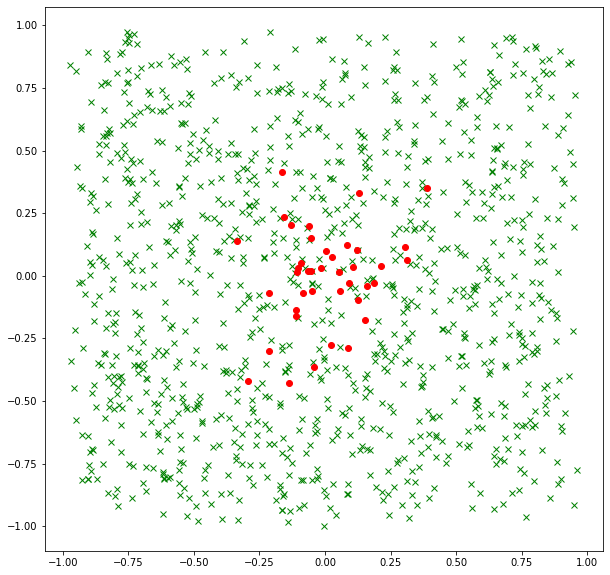

In [449]:
# neo4j graph
fig=  plt.figure(figsize=(10, 10))
users_df = embedding_df[embedding_df.index.isin(userID_df['u_id'].values)]
comedian_df = embedding_df[embedding_df.index.isin(comedianID_df['c_id'].values)]
e = np.array([i for i in users_df.embedding.values])
plt.plot(e[:,0], e[:,1],'gx')
e = np.array([i for i in comedian_df.embedding.values])
plt.plot(e[:,0], e[:,1],'ro')

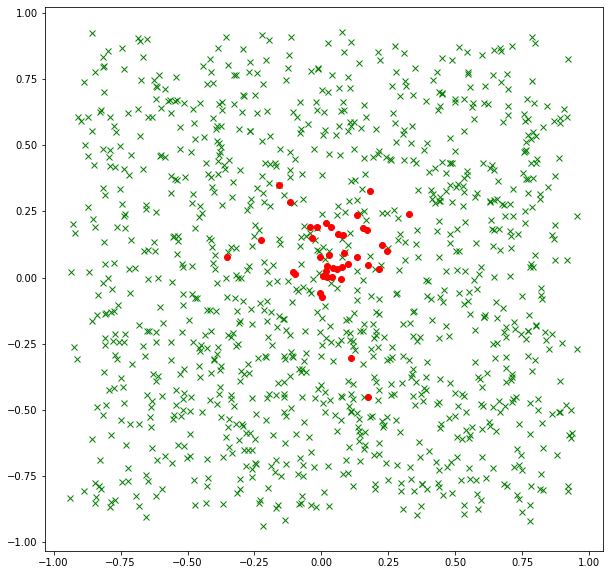

In [484]:
# scenario2 graph
fig=  plt.figure(figsize=(10, 10))
users_df = embedding_df[embedding_df.index.isin(userID_df['u_id'].values)]
comedian_df = embedding_df[embedding_df.index.isin(comedianID_df['c_id'].values)]
e = np.array([i for i in users_df.embedding.values])
plt.plot(e[:,0], e[:,1],'gx')
e = np.array([i for i in comedian_df.embedding.values])
plt.plot(e[:,0], e[:,1],'ro')

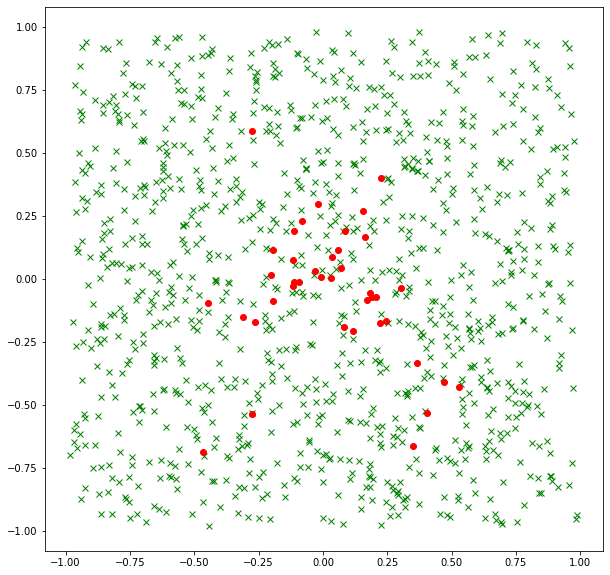

In [367]:
# scenario2 graph
fig=  plt.figure(figsize=(10, 10))
users_df = embedding_df[embedding_df.index.isin(userID_df['u_id'].values)]
comedian_df = embedding_df[embedding_df.index.isin(comedianID_df['c_id'].values)]


e = np.array([i for i in users_df.embedding.values])
plt.plot(e[:,0], e[:,1],'gx')
e = np.array([i for i in comedian_df.embedding.values])
plt.plot(e[:,0], e[:,1],'ro')

In [191]:
def get_embedding(node_id):
    return embedding_df.loc[node_id][0]

### Lookup node ids and relationships

In [485]:
# Retrieve comedian-id lookup table
query = "MATCH (n:Comedian) RETURN ID(n) as c_id, n.name as name"
comedianID_df = graph.run(query).to_data_frame()

# Retrieve user-id lookup table
query = "MATCH (n:User) RETURN ID(n) as u_id, n.name as name"
userID_df = graph.run(query).to_data_frame()
    

In [486]:
def map_dataset_id(graph, train_df, test_df):

    train_id = train_df.merge(userID_df, left_on='Name', right_on='name')
    train_id = train_id.merge(comedianID_df, left_on='Comedian', right_on='name')
    train_id = train_id[['u_id','c_id','Rating']]    
    train_id = train_id.rename(columns={'Rating': 'y'})
    
    test_id = test_df.merge(userID_df, left_on='Name', right_on='name')
    test_id = test_id.merge(comedianID_df, left_on='Comedian', right_on='name')
    test_id = test_id[['u_id','c_id','Rating']]    
    test_id = test_id.rename(columns={'Rating': 'y'})
    
    return train_id, test_id

In [487]:
train_ucID_base, test_ucID_base = map_dataset_id(graph, train_df, test_df)

In [488]:
def comedian_keyword(graph):    
    # query all comedian-keyword id relationships
    query = """
    MATCH (c:Comedian)-[:has_keyword]->(k:Keyword)
    WHERE ID(c) = $comedian_id
    RETURN ID(c) as c_id, COLLECT(DISTINCT ID(k)) as k_id
    """
    ckID_df = pd.DataFrame(columns=['c_id','k_id']) 
    for cid in comedianID_df.c_id:
        result = graph.run(query, comedian_id=cid)
        for k, v in result:
            ckID_df = ckID_df.append({'c_id': k, 'k_id':v}, ignore_index=True)

    # calculate the centroid of keywords for each 
    k_centroid = []
    for k, v in ckID_df.iterrows():
        vector = None
        for k_id in v['k_id']:
            if vector is None:
                vector = get_embedding(k_id)
            else:
                vector = np.add(get_embedding(k_id), vector)
        k_centroid.append(np.divide(vector, len(v['k_id'])))
    ckID_df['k_centroid'] = k_centroid

    # append one-hot encoding comedian properties to the matrix
    c2= cp_dummy.copy()
    c2["c_id"] = c2.index
    c2["c_id"] = c2["c_id"].apply(lambda x: comedianID_df[comedianID_df.name==x].c_id.values[0])
    ckID_merge = ckID_df.merge(c2, on='c_id')   
        
    return ckID_merge

In [489]:
ckID_base = comedian_keyword(graph)

In [490]:
def create_dataset(ucID_df, ckID_df):   
    # Merger this selected df with the ckID_df to append k_centroid
    merge_k_centroid = ucID_df.merge(ckID_df,on='c_id')
    merge_k_centroid = merge_k_centroid.drop('k_id', axis=1)
    
    # Translate u_id and c_id to embedding
    merge_k_centroid.u_id = merge_k_centroid.u_id.apply(get_embedding)
    merge_k_centroid.c_id = merge_k_centroid.c_id.apply(get_embedding)
    
    # Expend all embeddings to columns
    temp_u = merge_k_centroid.u_id.apply(pd.Series)
    temp_u = temp_u.rename(columns = lambda x : 'u' + str(x))
    temp_c = merge_k_centroid.c_id.apply(pd.Series)
    temp_c = temp_c.rename(columns = lambda x : 'c' + str(x))
    temp_k = merge_k_centroid.k_centroid.apply(pd.Series)
    temp_k = temp_k.rename(columns = lambda x : 'k' + str(x))
    
    dataset = pd.concat([merge_k_centroid, temp_u[:], temp_c[:], temp_k[:]], axis=1)
    dataset = dataset.drop(['u_id','c_id','k_centroid'], axis=1)
    return dataset    

In [491]:
train_dataset = create_dataset(train_ucID_base, ckID_base)
train_dataset.to_pickle('train_dataset.pkl')
train_dataset

,y,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,Married_True,...,u2,u3,c0,c1,c2,c3,k0,k1,k2,k3
0,0.250000,0,0,0,0,0,0,0,1,0,...,-0.648848,0.441313,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
1,0.550000,0,0,0,0,0,0,0,1,0,...,0.110672,-0.014171,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
2,0.100000,0,0,0,0,0,0,0,1,0,...,-0.884607,-0.132899,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
3,0.450000,0,0,0,0,0,0,0,1,0,...,-0.573020,0.455453,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
4,0.812500,0,0,0,0,0,0,0,1,0,...,-0.524527,-0.118715,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7252,1.000000,1,0,0,0,0,0,0,0,1,...,0.247709,-0.615871,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469
7253,0.200000,1,0,0,0,0,0,0,0,1,...,0.495883,0.448396,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469
7254,0.132407,1,0,0,0,0,0,0,0,1,...,0.750049,0.147722,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469
7255,0.350000,1,0,0,0,0,0,0,0,1,...,0.906057,-0.235264,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469


In [492]:
test_dataset = create_dataset(test_ucID_base, ckID_base)
test_dataset.to_pickle('test_dataset.pkl')
test_dataset

,y,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,Married_True,...,u2,u3,c0,c1,c2,c3,k0,k1,k2,k3
0,1.000000,0,1,0,0,0,0,0,0,0,...,-0.086379,0.040426,0.245767,0.101491,-0.033551,-0.024893,0.031683,0.043121,0.079402,0.062404
1,0.575000,0,1,0,0,0,0,0,0,0,...,-0.602584,0.269805,0.245767,0.101491,-0.033551,-0.024893,0.031683,0.043121,0.079402,0.062404
2,1.000000,0,1,0,0,0,0,0,0,0,...,-0.832380,0.598559,0.245767,0.101491,-0.033551,-0.024893,0.031683,0.043121,0.079402,0.062404
3,0.525000,0,1,0,0,0,0,0,0,0,...,-0.010008,0.001532,0.245767,0.101491,-0.033551,-0.024893,0.031683,0.043121,0.079402,0.062404
4,0.731250,0,1,0,0,0,0,0,0,0,...,-0.125698,-0.851460,0.245767,0.101491,-0.033551,-0.024893,0.031683,0.043121,0.079402,0.062404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810,1.000000,0,0,0,0,0,0,0,1,0,...,-0.561376,0.098458,-0.353043,0.078090,-0.191743,0.236870,0.010418,-0.037446,0.016402,-0.016174
1811,0.356349,0,0,0,0,0,0,0,1,0,...,0.304866,-0.387227,-0.353043,0.078090,-0.191743,0.236870,0.010418,-0.037446,0.016402,-0.016174
1812,0.650000,0,0,0,0,0,0,0,1,0,...,0.304906,-0.250787,-0.353043,0.078090,-0.191743,0.236870,0.010418,-0.037446,0.016402,-0.016174
1813,0.333333,0,0,0,0,0,0,0,1,0,...,0.108676,-0.680268,-0.353043,0.078090,-0.191743,0.236870,0.010418,-0.037446,0.016402,-0.016174


### Classification

#### Feature Selection

In [493]:
from sklearn.feature_selection import SelectPercentile

In [494]:
train_dataset_cat = pd.read_pickle('train_dataset.pkl')
train_dataset_cat.y = train_dataset_cat.y.apply(lambda x: 1 if x >= 0.5 else 0)
test_dataset_cat = pd.read_pickle('test_dataset.pkl')
test_dataset_cat.y = test_dataset_cat.y.apply(lambda x: 1 if x >= 0.5 else 0)
train_dataset_cat

,y,Citizenship_Canada,Citizenship_India,Citizenship_New Zealand,Citizenship_People's Republic of China,Citizenship_Philippines,Citizenship_South Africa,Citizenship_United Kingdom,Citizenship_United States of America,Married_True,...,u2,u3,c0,c1,c2,c3,k0,k1,k2,k3
0,0,0,0,0,0,0,0,0,1,0,...,-0.648848,0.441313,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
1,1,0,0,0,0,0,0,0,1,0,...,0.110672,-0.014171,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
2,0,0,0,0,0,0,0,0,1,0,...,-0.884607,-0.132899,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
3,0,0,0,0,0,0,0,0,1,0,...,-0.573020,0.455453,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
4,1,0,0,0,0,0,0,0,1,0,...,-0.524527,-0.118715,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7252,1,1,0,0,0,0,0,0,0,1,...,0.247709,-0.615871,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469
7253,0,1,0,0,0,0,0,0,0,1,...,0.495883,0.448396,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469
7254,0,1,0,0,0,0,0,0,0,1,...,0.750049,0.147722,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469
7255,0,1,0,0,0,0,0,0,0,1,...,0.906057,-0.235264,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469


In [495]:
X_train = train_dataset_cat.values[:,1:]
Y_train = train_dataset_cat.values[:,0]
X_test = test_dataset_cat.values[:,1:]
Y_test = test_dataset_cat.values[:,0]

In [496]:
select = SelectPercentile(percentile=90)
select.fit(X_train, Y_train)
x_train_selected = select.transform(X_train)
x_test_selected = select.transform(X_test)
pd.DataFrame(x_train_selected)

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.136092,0.441313,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,-0.580228,-0.014171,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.462282,-0.132899,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,-0.565707,0.455453,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,-0.667986,-0.118715,0.169194,0.179598,0.158009,-0.084910,0.065133,-0.042955,0.039214,-0.039833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7252,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.260229,-0.615871,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469
7253,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.244487,0.448396,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469
7254,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.158730,0.147722,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469
7255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.422737,-0.235264,0.175699,-0.451615,-0.307100,-0.369318,-0.001913,-0.107575,-0.042244,-0.001469


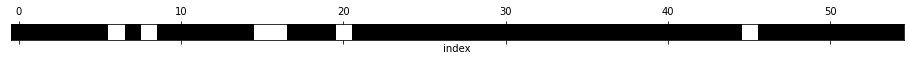

In [497]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap="gray_r")
plt.xlabel('index')
plt.yticks(());

In [498]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [499]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
# from keras.models import Sequential
# from keras.layers import Dense

#### Cross Vaidation

In [385]:
models = []
models.append(('RD', DummyClassifier(strategy='uniform')))
models.append(('LR',make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('DT',DecisionTreeClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))))
models.append(('XGB',make_pipeline(StandardScaler(), XGBClassifier())))
models.append(('MLP',MLPClassifier(hidden_layer_sizes=[100,100],activation='logistic')))

In [386]:
names = []
results = []
means = []
sdevs = []
scoring = 'accuracy'

In [387]:
for name,model in models:
    cv_method = StratifiedKFold(n_splits = 20)
    cv_results = cross_val_score(model,x_train_selected,Y_train,cv=cv_method,scoring=scoring)
    results.append(cv_results)
    means.append(cv_results.mean())
    sdevs.append(cv_results.std())
    names.append(name)
    print(f"{name} done.")

RD done.
LR done.
LDA done.
KNN done.
DT done.
RF done.
NB done.
SVM done.
XGB done.
MLP done.


In [388]:
df1 = pd.DataFrame()
df1['name'] = names
df1[f'mean {scoring}'] = means
df1[f'{scoring} std dev'] = sdevs
df1

,name,mean accuracy,accuracy std dev
0,RD,0.496633,0.025212
1,LR,0.523221,0.161561
2,LDA,0.516070,0.169914
3,KNN,0.515949,0.134471
4,DT,0.489062,0.121776
5,RF,0.491289,0.142464
6,NB,0.556538,0.169146
7,SVM,0.539654,0.158534
8,XGB,0.565544,0.138323
9,MLP,0.622299,0.119662


Text(0, 0.5, 'Test accuracy Rate')

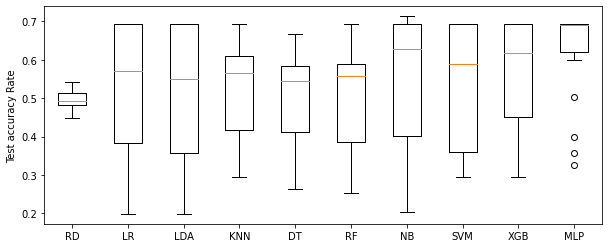

In [389]:
plt.figure(figsize=(10,4))
plt.boxplot(results)
plt.xticks(range(1,11),names)
plt.ylabel(f'Test {scoring} Rate')

### t-score evaluation

In [390]:
from scipy.stats import ttest_ind as ttest

In [391]:
best = results[-1] #MLP
best

array([0.69230769, 0.68044077, 0.32506887, 0.69421488, 0.69421488,
       0.35812672, 0.69421488, 0.69421488, 0.63360882, 0.69421488,
       0.69421488, 0.62809917, 0.69421488, 0.60055096, 0.39944904,
       0.68870523, 0.69337017, 0.69060773, 0.69337017, 0.50276243])

In [392]:
for r, n in zip(results, names):
    # The best model
    if n == 'MLP':
        continue
    print(f"MLP vs. {n}: p-value = {ttest(best, r)[0]}")

MLP vs. RD: p-value = 4.479228845676908
MLP vs. LR: p-value = 2.1480848450171974
MLP vs. LDA: p-value = 2.2280678511660343
MLP vs. KNN: p-value = 2.5752972295512544
MLP vs. DT: p-value = 3.4016617841633776
MLP vs. RF: p-value = 3.0693563473561385
MLP vs. NB: p-value = 1.3834488048009166
MLP vs. SVM: p-value = 1.8136531540000236
MLP vs. XGB: p-value = 1.352598011417183


## Hyperparameter tuning

In [393]:
def evaluate(model, x, y):    
     #Predict training set:
    y_pred = model.predict(x)
        
    #Print model report:
    df = pd.DataFrame(confusion_matrix(y, y_pred), index=[0, 1], columns=[0, 1])
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print(f"Precision = {tp/(tp+fp):0.3f}")
    print(f"Recall = {tp/(tp+fn):0.3f}")
    print(f"Accuracy = {(tn+tp)/len(y)}")
    
    return df

#### LR

In [11]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=param_grid, cv=None)
grid.fit(x_train_selected, Y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.001} with a score of 0.69


In [241]:
param_grid = {'C': np.linspace(0.0001, 0.001, num=100) }
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=param_grid, cv=None)
grid.fit(x_train_selected, Y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.0001} with a score of 0.69


In [242]:
 grid.best_estimator_.score(x_test_selected, Y_test)

0.6986225895316804

In [243]:
y_pred = grid.best_estimator_.predict(x_test_selected)
pd.DataFrame(confusion_matrix(Y_test, y_pred), index= [-1, 1], columns=[-1, 1])

,-1,1
-1,0,547
1,0,1268


#### SVM

In [237]:
svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='auto'))
svm = svc.fit(x_train_selected, Y_train)

In [238]:
evaluate(svm, x_train_selected, Y_train)

Precision = 0.698
Recall = 0.993
Accuracy = 0.6969822240595287


,0,1
0,55,2166
1,33,5003


In [240]:
evaluate(svm, x_test_selected, Y_test)

Precision = 0.704
Recall = 0.992
Accuracy = 0.703030303030303


,0,1
0,18,529
1,10,1258


In [339]:
pre = []
for c in range(1,21):
    svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=c, gamma='auto'))
    kfold = StratifiedKFold(n_splits=10,random_state=1)
    result = cross_val_score(svc,x_train_selected,Y_train,cv=kfold,scoring="precision")
    pre.append(result.mean())

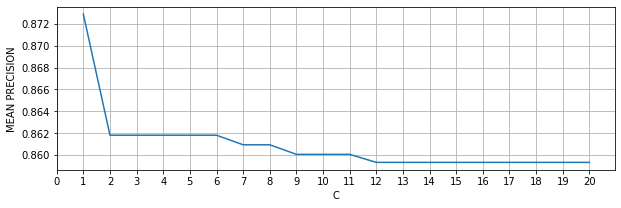

In [340]:
fig = plt.figure(figsize=(10,3))
plt.plot([x for x in range(1, 21)], pre)
x_range = range(0,21)
y_range = range(0,21)
plt.xlabel('C')
plt.ylabel('MEAN PRECISION')
plt.xticks(x_range, y_range)
plt.grid()

Good resource for SVM:

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(x_train_selected, Y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [ ]:
svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma']))
svc.fit(x_train_selected, Y_train)
svc.score(x_test_selected, Y_test)

In [ ]:
y_pred = svc.predict(x_test_selected)
pd.DataFrame(confusion_matrix(Y_test, y_pred), index= [-1, 1], columns=[-1, 1])

In [ ]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print(f"Precision = {tp/(tp+fp):0.3f}")
print(f"Recall = {tp/(tp+fn):0.3f}")

#### Random Forest

ref: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74#:~:text=%20Hyperparameter%20Tuning%20the%20Random%20Forest%20in%20Python,we%20only%20have%20a%20vague%20idea...%20More%20

In [311]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [312]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [313]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

rf_random.fit(x_train_selected, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [314]:
print("The best parameters are %s\n with a score of %0.2f"
      % (rf_random.best_params_, rf_random.best_score_))

The best parameters are {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
 with a score of 0.87


In [315]:
y_pred = rf_random.best_estimator_.predict(x_test_selected)
pd.DataFrame(confusion_matrix(Y_test, y_pred), index=[-1, 1], columns=[-1, 1])

,-1,1
-1,0,11
1,0,69


In [316]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print(f"Precision = {tp/(tp+fp):0.3f}")
print(f"Recall = {tp/(tp+fn):0.3f}")

Precision = 0.863
Recall = 1.000


#### XGBoosting

ref: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [500]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [502]:
def modelfit(alg, x, y, param = None):
    
    if param is not None:
        grid_search = GridSearchCV(alg, param, scoring='accuracy',cv=None,n_jobs=-1)
        result = grid_search.fit(x, y)
        best = grid_search.best_estimator_
    else:
        result = alg.fit(x, y)
        best = alg
        
    return best

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 n_jobs=-1,
 scale_pos_weight=1,
 seed=27)
model = modelfit(xgb1, x_train_selected, Y_train)

In [ ]:
evaluate(model, x_train_selected, Y_train)

In [ ]:
evaluate(model, x_test_selected, Y_test)

In [ ]:
xgb_pred = model.predict(x_test_selected)
pickle.dump(xgb_pred, open('scenario1_xgb_pred.pkl', 'wb'))

In [399]:
grid_param = {
 'gamma':[i/10.0 for i in range(0,5)],    
 'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2),
#  'max_depth':[4,5,6],
#  'min_child_weight':[4,5,6]
}
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 scale_pos_weight=1,
 n_jobs=-1,
 seed=27)

model2 = modelfit(xgb2, x_train_selected, Y_train, grid_param)

KeyboardInterrupt: 

In [ ]:
evaluate(model2, x_train_selected, Y_train)

In [ ]:
evaluate(model2, x_test_selected, Y_test)

#### MLP

In [507]:
from sklearn.neural_network import MLPClassifier

In [508]:
mlp = MLPClassifier(hidden_layer_sizes=[100,100], learning_rate_init=0.001,activation='logistic')
mlp.fit(x_train_selected, Y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[100, 100], learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [509]:
evaluate(mlp, x_train_selected, Y_train)

Precision = 0.696
Recall = 0.996
Accuracy = 0.6953286482017362


,0,1
0,31,2190
1,21,5015


In [510]:
evaluate(mlp, x_test_selected, Y_test)

Precision = 0.702
Recall = 0.994
Accuracy = 0.7008264462809918


,0,1
0,11,536
1,7,1261


In [404]:
score = []
x_axis = np.linspace(0.08, 0.5, 20)
for i in x_axis:
    kfold = StratifiedKFold(n_splits=10,random_state=1)
    mlp = MLPClassifier(hidden_layer_sizes=[100,100],learning_rate_init = i, activation='logistic')
    result = cross_val_score(mlp,x_train_selected,Y_train,cv=kfold,scoring="precision")
    score.append(result.mean())

Text(0, 0.5, 'accuracy')

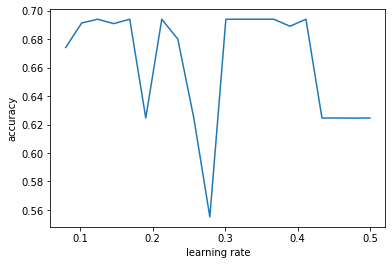

In [405]:
plt.plot(x_axis, score)
plt.xlabel('learning rate')
plt.ylabel('accuracy')

In [406]:
x_axis

array([0.08      , 0.10210526, 0.12421053, 0.14631579, 0.16842105,
       0.19052632, 0.21263158, 0.23473684, 0.25684211, 0.27894737,
       0.30105263, 0.32315789, 0.34526316, 0.36736842, 0.38947368,
       0.41157895, 0.43368421, 0.45578947, 0.47789474, 0.5       ])

In [407]:
score = []
for i in np.linspace(0.00001, 0.01, 20):    
    kfold = StratifiedKFold(n_splits=10,random_state=1)
    mlp = MLPClassifier(hidden_layer_sizes=[100,100],alpha = i, activation='logistic')
    result = cross_val_score(mlp,x_train_selected,Y_train,cv=kfold,scoring="precision")
    score.append(result.mean())

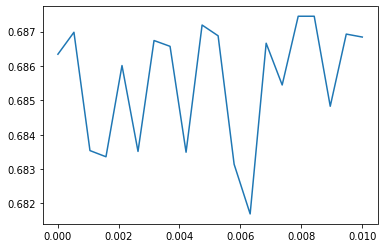

In [408]:
plt.plot(np.linspace(0.00001, 0.01, 20), score)

In [511]:
mlp = MLPClassifier(hidden_layer_sizes=[100,100], alpha=0.008, max_iter=500 ,activation='logistic')
mlp.fit(x_train_selected, Y_train)

MLPClassifier(activation='logistic', alpha=0.008, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[100, 100], learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [512]:
evaluate(mlp, x_train_selected, Y_train)

Precision = 0.696
Recall = 0.997
Accuracy = 0.6954664461898856


,0,1
0,24,2197
1,13,5023


In [513]:
evaluate(mlp, x_test_selected, Y_test)

Precision = 0.701
Recall = 0.996
Accuracy = 0.7008264462809918


,0,1
0,9,538
1,5,1263


In [514]:
mlp_pred = mlp.predict(x_test_selected)
pickle.dump(mlp_pred, open('scenario1_mlp_pred.pkl', 'wb'))

#### Neural Network

ref: https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Accuracy
from keras.utils import np_utils
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split

In [37]:
from keras.optimizers import SGD

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_train_selected, Y_train, test_size=0.2,random_state=42)

In [39]:
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
metrics_cat = 'binary_accuracy'
metrics_reg = 'mae'

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [40]:
input_dim = len(x_train_selected[0])

# model = Sequential()
# model.add(Dense(100, activation='relu', input_shape=(input_dim,)))# input_shape = reshape for 13 features 
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1))

# model.compile(optimizer = sgd, loss = 'mse', metrics=[metrics_reg]) #root-mean-square, mae='mean absolute error'
# history = model.fit(x_train, y_train, epochs = epochs, batch_size=1, validation_data=(x_test, y_test))

##
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(input_dim,)))# input_shape = reshape for 13 features 
model.add(Dense(100, activation='relu')) 
# model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=sgd, 
              loss='categorical_crossentropy', 
              metrics=[metrics_cat])
y_train = [0 if y == -1 else 1 for y in y_train]
y_train2 = to_categorical(y_train)
y_test = [0 if y == -1 else 1 for y in y_test]
y_test2 = to_categorical(y_test)
history = model.fit(x_train, y_train2, epochs = epochs, batch_size=1, validation_data=(x_test, y_test2))
##


Train on 5805 samples, validate on 1452 samples
Epoch 1/20
5805/5805 [==============================] - 3s 552us/step - loss: 3.0052e-04 - binary_accuracy: 1.0000 - val_loss: 3.2497e-05 - val_binary_accuracy: 1.0000
Epoch 2/20
5805/5805 [==============================] - 3s 523us/step - loss: 3.1199e-05 - binary_accuracy: 1.0000 - val_loss: 2.8104e-05 - val_binary_accuracy: 1.0000
Epoch 3/20
5805/5805 [==============================] - 3s 524us/step - loss: 2.8087e-05 - binary_accuracy: 1.0000 - val_loss: 2.6027e-05 - val_binary_accuracy: 1.0000
Epoch 4/20
5805/5805 [==============================] - 3s 523us/step - loss: 2.6378e-05 - binary_accuracy: 1.0000 - val_loss: 2.4721e-05 - val_binary_accuracy: 1.0000
Epoch 5/20
5805/5805 [==============================] - 3s 535us/step - loss: 2.5234e-05 - binary_accuracy: 1.0000 - val_loss: 2.3787e-05 - val_binary_accuracy: 1.0000
Epoch 6/20
5805/5805 [==============================] - 3s 557us/step - loss: 2.4387e-05 - binary_accuracy: 1.00

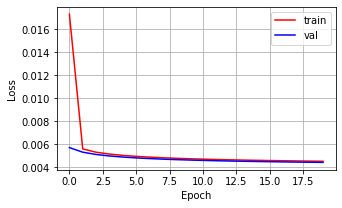

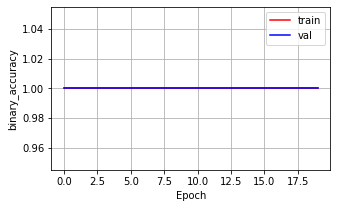

In [41]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.legend()
ax.grid()
ax.tick_params()

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(np.sqrt(history.history[metrics_cat]), 'r', label='train')
ax.plot(np.sqrt(history.history[f'val_{metrics_cat}']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(metrics_cat)
ax.legend()
ax.grid()
ax.tick_params()

In [42]:
y_pred = model.predict(x_train_selected)
# y_pred = [1 if y >= 0 else -1 for y in y_pred]
y_pred = [np.argmax(y)*2-1 for y in y_pred]
pd.DataFrame(confusion_matrix(Y_train, y_pred), index=[-1, 1], columns=[-1, 1])

,-1,1
-1,0,2221
1,0,5036


In [328]:
# loss, acc = model.evaluate(x_test_selected, Y_test,verbose=0) 
y_t = to_categorical([0 if y == -1 else 1 for y in Y_test])
loss, acc = model.evaluate(x_test_selected, y_t, verbose=0)
print(f"Test Loss ={loss}\nTest Accuracy = {acc}")

Test Loss =1.5488326787948608
Test Accuracy = 0.800000011920929


In [329]:
y_pred = model.predict(x_test_selected)
# y_pred = [1 if y >= 0 else -1 for y in y_pred]
y_pred = [np.argmax(y)*2-1 for y in y_pred]
pd.DataFrame(confusion_matrix(Y_test, y_pred), index=[-1, 1], columns=[-1, 1])

,-1,1
-1,1,10
1,6,63


In [330]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print(f"Precision = {tp/(tp+fp):0.3f}")
print(f"Recall = {tp/(tp+fn):0.3f}")

Precision = 0.863
Recall = 0.913
